# Lagged variables in the LSTM

In [182]:
# required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from keras.callbacks import EarlyStopping
from keras.models import Sequential, load_model
from keras.layers import LSTM, Dense, Dropout
import hydroeval as he
import keras_tuner as kt
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.models import model_from_json
import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import kerastuner as kt
import hydroeval as he
import warnings
warnings.filterwarnings('ignore')
import os

In [3]:
# loading the data
df_test=pd.read_csv('/Users/thijskalshoven/Documents/UU_data_science/6_THESIS_Streamflow_predictions/Data/Clustering/test_cluster2.csv')
df_train=pd.read_csv('/Users/thijskalshoven/Documents/UU_data_science/6_THESIS_Streamflow_predictions/Data/Clustering/train_cluster2.csv')

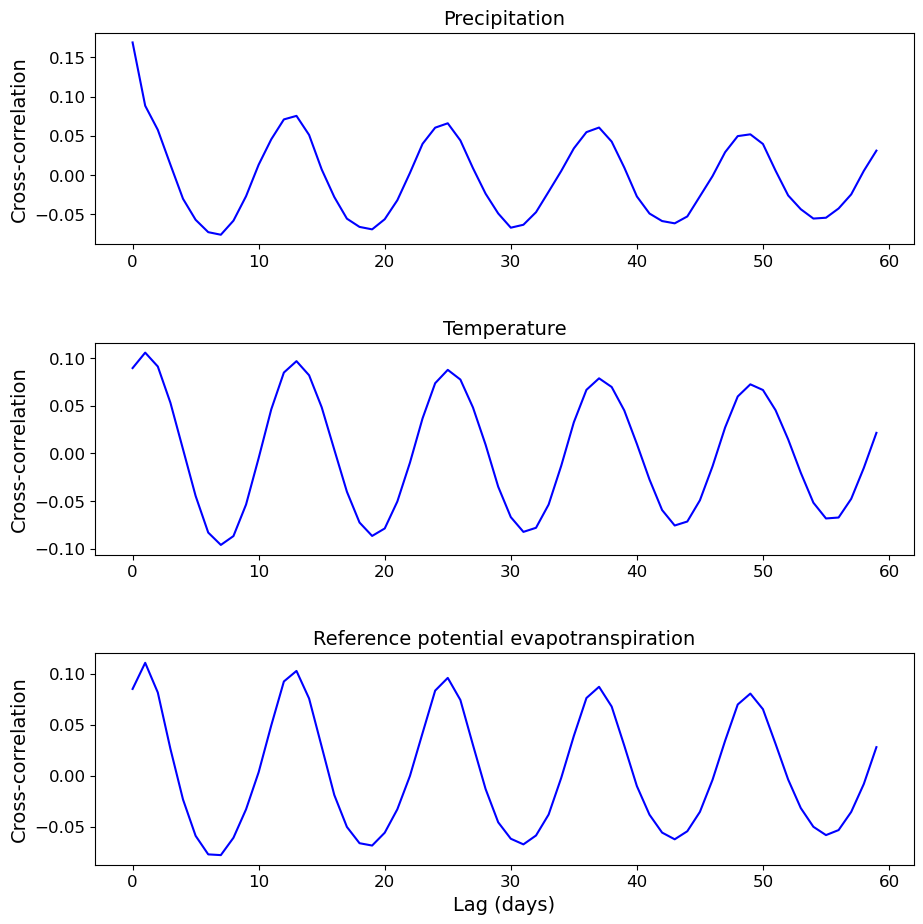

In [6]:
# Do CC plots in order to find the best lag
def crosscorr(datax, datay, lag=0, wrap=False):
    """ Lag-N cross correlation. 
    Shifted data filled with NaNs 
    The lag is in terms of units of datay's index. """
    if wrap:
        shiftedy = datay.shift(lag)
        shiftedy.iloc[:lag] = datay.iloc[-lag:].values
        return datax.corr(shiftedy)
    else:
        return datax.corr(datay.shift(lag))

# CC plots
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(10, 10))
fig.tight_layout(pad=5.0)
axes[0].xaxis.set_tick_params(labelsize=12)
axes[0].yaxis.set_tick_params(labelsize=12)
axes[1].xaxis.set_tick_params(labelsize=12)
axes[1].yaxis.set_tick_params(labelsize=12)
axes[2].xaxis.set_tick_params(labelsize=12)
axes[2].yaxis.set_tick_params(labelsize=12)
axes[0].set_title('Precipitation', fontsize=14)
axes[1].set_title('Temperature', fontsize=14)
axes[2].set_title('Reference potential evapotranspiration', fontsize=14)
axes[0].set_ylabel('Cross-correlation', fontsize=14)
axes[1].set_ylabel('Cross-correlation', fontsize=14)
axes[2].set_ylabel('Cross-correlation', fontsize=14)
axes[2].set_xlabel('Lag (month)', fontsize=14)
axes[0].plot([crosscorr(df_train['precipitation'], df_train['obs'], lag=i) for i in range(60)], color='blue')
axes[1].plot([crosscorr(df_train['temperature'], df_train['obs'], lag=i) for i in range(60)], color='blue')
axes[2].plot([crosscorr(df_train['referencePotET'], df_train['obs'], lag=i) for i in range(60)], color='blue')
plt.show()


In [7]:
# check NA values in train and test
print(df_train.obs.isna().sum()/len(df_train.obs))
print(df_test.obs.isna().sum()/len(df_test.obs))

# print amount of zeros in train and test
print('\n')
print(len(df_train[df_train.obs==0])/len(df_train.obs))
print(len(df_test[df_test.obs==0])/len(df_test.obs))

0.0
0.0


0.10506230529595016
0.07576312576312576


# LSTM on six variables

In [28]:
# x  and y train
y_train = df_train.obs
X_train = df_train[['precipitation','temperature','referencePotET','aridityIdx','satWC1','airEntry1']] #,'gwRecharge','storLowTotal','totalEvaporation','interflowTotal','surfaceWaterStorage','snowCoverSWE']]


# x and y test
y_test = df_test.obs
X_test = df_test[['precipitation','temperature','referencePotET','aridityIdx', 'satWC1','airEntry1']]  #,'gwRecharge','storLowTotal','totalEvaporation','interflowTotal','surfaceWaterStorage','snowCoverSWE']]
print(y_test.shape, y_train.shape, X_test.shape, X_train.shape)

(16380,) (38520,) (16380, 6) (38520, 6)


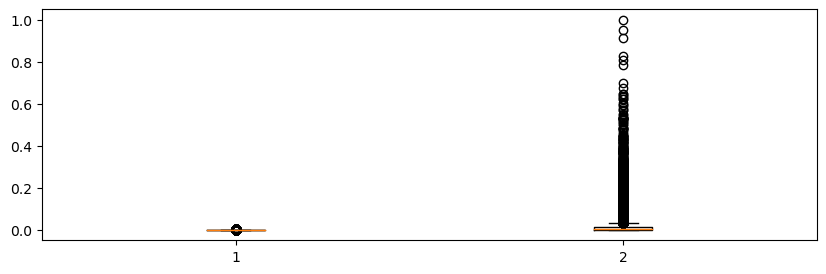

In [21]:
# normalising output
y_train_shaped = np.reshape(y_train.values, (y_train.shape[0],1))
mmscaler = MinMaxScaler()
y_train_scaled = mmscaler.fit_transform(y_train_shaped)
y_test_shaped = np.reshape(y_test.values, (y_test.shape[0],1))
y_test_scaled = mmscaler.transform(y_test_shaped)

# make the y_train_scaled just one array
y_train_box= y_train_scaled.ravel()
# see difference between scaled and unscaled
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(10, 3))
plt.boxplot([y_train, y_train_box])
plt.show()

In [22]:
def lstm_data_transform(x_data, y_data, num_steps=12):
    """ Changes data to the format for LSTM training
    for sliding window approach """
    # Prepare the list for the transformed data
    X, y = list(), list()
    # Loop of the entire data set
    for i in range(x_data.shape[0]):
        end_ix = i + num_steps
        # if index is larger than the size of the dataset, we stop
        if end_ix >= x_data.shape[0]:
            break
        seq_X = x_data[i:end_ix]
        seq_y = y_data[end_ix]
        X.append(seq_X)
        y.append(seq_y)

    # Make final arrays
    x_array = np.array(X)
    y_array = np.array(y)
    return x_array, y_array

In [23]:
# define the number of steps based on CC plots (12)
num_steps = 12

# training set
(X_train_transformed,
 y_train_transformed) = lstm_data_transform(X_train, y_train_scaled, num_steps=num_steps)
assert X_train_transformed.shape[0] == y_train_transformed.shape[0]

# test set
(X_test_transformed,
 y_test_transformed) = lstm_data_transform(X_test, y_test_scaled, num_steps=num_steps)
assert X_test_transformed.shape[0] == y_test_transformed.shape[0]

print(X_train_transformed.shape, y_train_transformed.shape, X_test_transformed.shape, y_test_transformed.shape)

(38508, 12, 6) (38508, 1) (16368, 12, 6) (16368, 1)


In [248]:
# saving obs of test set
y_test_inversed = mmscaler.inverse_transform(y_test_transformed) 
y_test_inversed
np.save("/Users/thijskalshoven/Documents/UU_data_science/6_THESIS_Streamflow_predictions/Data/LSTM/train_table_allpredictors.npy", y_test_inversed, allow_pickle=True)

In [249]:
input_unit = 512
n_layers = 1 
lstm_0_units = 128
layer_2_neurons = 64 
dropout_rate = 0.3
dense_activation = 'tanh' 
learning_rate = 0.001

# Build the model
model = Sequential()
model.add(LSTM(input_unit, return_sequences=True))
for i in range(n_layers):
    model.add(LSTM(eval(f'lstm_{i}_units'), return_sequences=True))
model.add(LSTM(layer_2_neurons))
model.add(Dropout(dropout_rate))
model.add(Dense(1, activation=dense_activation))
model.compile(loss='mean_squared_error', optimizer=keras.optimizers.Adam(learning_rate), metrics=['mse'])

# Create callback for early stopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=7, restore_best_weights=True)

# Run the model
history = model.fit(X_train_transformed, y_train_transformed,
                    validation_split=0.2,
                    epochs=30,
                    batch_size=64,
                    callbacks=[es])


Epoch 1/30


2023-06-07 15:36:23.555986: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-07 15:36:23.557986: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-07 15:36:23.559512: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

482/482 [==============================] - ETA: 0s - loss: 0.0019 - mse: 0.0019

2023-06-07 15:37:30.811338: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-07 15:37:30.813516: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-07 15:37:30.815193: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

482/482 [==============================] - 72s 135ms/step - loss: 0.0019 - mse: 0.0019 - val_loss: 0.0025 - val_mse: 0.0025
Epoch 2/30
482/482 [==============================] - 64s 133ms/step - loss: 0.0015 - mse: 0.0015 - val_loss: 0.0028 - val_mse: 0.0028
Epoch 3/30
482/482 [==============================] - 64s 132ms/step - loss: 0.0014 - mse: 0.0014 - val_loss: 0.0027 - val_mse: 0.0027
Epoch 4/30
482/482 [==============================] - 191s 397ms/step - loss: 0.0014 - mse: 0.0014 - val_loss: 0.0027 - val_mse: 0.0027
Epoch 5/30
482/482 [==============================] - 66s 137ms/step - loss: 0.0013 - mse: 0.0013 - val_loss: 0.0029 - val_mse: 0.0029
Epoch 6/30
482/482 [==============================] - 64s 133ms/step - loss: 0.0013 - mse: 0.0013 - val_loss: 0.0031 - val_mse: 0.0031
Epoch 7/30
482/482 [==============================] - 64s 132ms/step - loss: 0.0013 - mse: 0.0013 - val_loss: 0.0030 - val_mse: 0.0030
Epoch 8/30
482/482 [==============================] - 64s 133ms/s

In [250]:
model.summary()

Model: "sequential_54"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_162 (LSTM)             (None, 12, 512)           1062912   
                                                                 
 lstm_163 (LSTM)             (None, 12, 128)           328192    
                                                                 
 lstm_164 (LSTM)             (None, 64)                49408     
                                                                 
 dropout_54 (Dropout)        (None, 64)                0         
                                                                 
 dense_54 (Dense)            (None, 1)                 65        
                                                                 
Total params: 1,440,577
Trainable params: 1,440,577
Non-trainable params: 0
_________________________________________________________________


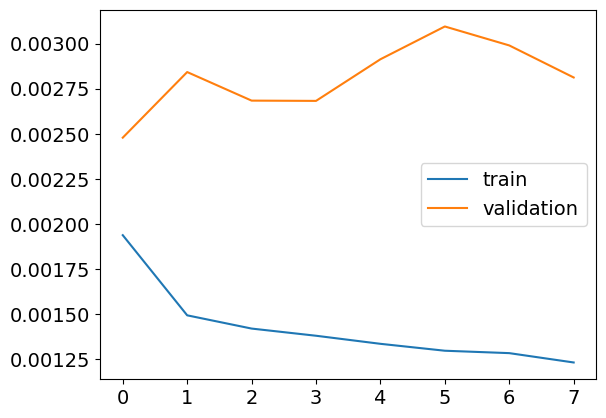

In [251]:
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.legend()
plt.show()

In [252]:
# mse evaluation
res = model.evaluate(X_test_transformed, y_test_transformed, verbose=0)

print(f'MSE on the test set : {res[1]:.4f}')

MSE on the test set : 0.0016


In [259]:
y_pred = model.predict(X_test_transformed)
# nse evaluation
nse = he.evaluator(he.nse,y_pred,y_test_transformed)
print('nse:', nse[0])

# kge evaluation
kge = he.evaluator(he.kge, y_pred, y_test_transformed)
print('kge:', kge[0])

512/512 [==============================] - 12s 24ms/step
nse: 0.14370877767258716
kge: [0.17080933]


# LSTM with Lagged and non-lagged layer

In [193]:
df_test = pd.read_csv('/Users/thijskalshoven/Documents/UU_data_science/6_THESIS_Streamflow_predictions/Data/Clustering/test_cluster2.csv')
df_train = pd.read_csv('/Users/thijskalshoven/Documents/UU_data_science/6_THESIS_Streamflow_predictions/Data/Clustering/train_cluster2.csv')

# x and y train
y_train = df_train.obs
X_train = df_train[['precipitation', 'temperature', 'referencePotET', 'aridityIdx', 'satWC1', 'airEntry1']]#,'slopeLength','groundwaterDepth','gwRecharge','storLowTotal']]

# x and y test
y_test = df_test.obs
X_test = df_test[['precipitation', 'temperature', 'referencePotET', 'aridityIdx', 'satWC1', 'airEntry1']]#,'slopeLength','groundwaterDepth','gwRecharge','storLowTotal']]

# print(y_test.shape, y_train.shape, X_test.shape, X_train.shape)

# Normalizing output
mmscaler = MinMaxScaler()
y_train_scaled = mmscaler.fit_transform(y_train.values.reshape(-1, 1))
y_test_scaled = mmscaler.transform(y_test.values.reshape(-1, 1))


def lstm_data_transform(x_data, y_data, num_steps=12):
    """ Changes data to the format for LSTM training
    for sliding window approach """
    # Prepare the list for the transformed data
    X, y = list(), list()
    # Loop over the entire data set
    for i in range(x_data.shape[0]):
        end_ix = i + num_steps
        if end_ix >= x_data.shape[0]:
            break
        seq_X = x_data[i:end_ix]
        seq_y = y_data[end_ix]
        X.append(seq_X)
        y.append(seq_y)

    x_array = np.array(X)
    y_array = np.array(y)
    return x_array, y_array

# Define the number of steps based on CC plots
num_steps = 12

# Training set
(X_train_transformed, y_train_transformed) = lstm_data_transform(X_train, y_train_scaled, num_steps=num_steps)
assert X_train_transformed.shape[0] == y_train_transformed.shape[0]

# Test set
(X_test_transformed, y_test_transformed) = lstm_data_transform(X_test, y_test_scaled, num_steps=num_steps)
assert X_test_transformed.shape[0] == y_test_transformed.shape[0]

print(X_train_transformed.shape, y_train_transformed.shape, X_test_transformed.shape, y_test_transformed.shape,'\n')

input_unit = 480
n_layers = 3
lstm_0_units = 256
lstm_1_units = 256
lstm_2_units = 256
layer_2_neurons = 256
dropout_rate = 0.4
dense_activation = 'relu'
learning_rate = 0.001

# Build the model
model = Sequential()
# Add the lagged variables as LSTM layers
model.add(LSTM(lstm_0_units, return_sequences=True))
for i in range(1, n_layers):
    model.add(LSTM(eval(f'lstm_{i}_units'), return_sequences=True))
    # add dropout layer
    model.add(Dropout(dropout_rate))

# Add the non-lagged variables as a fully connected layer
model.add(Dense(layer_2_neurons, activation=dense_activation))

# Add dropout layer
model.add(Dropout(dropout_rate))

# Add output layer
model.add(Dense(1, activation='linear'))

# Compile the model
model.compile(loss='mean_squared_error', optimizer=keras.optimizers.Adam(learning_rate), metrics=['mse'])

# Create callback for early stopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5, restore_best_weights=True)

# Train the model
history = model.fit(X_train_transformed, y_train_transformed,
                    validation_split=0.2,
                    epochs=30,
                    batch_size=64,
                    callbacks=[es])

(38508, 12, 10) (38508, 1) (16368, 12, 10) (16368, 1) 

Epoch 1/30


2023-06-16 08:54:50.679665: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-16 08:54:50.680800: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-16 08:54:50.682531: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

481/482 [============================>.] - ETA: 0s - loss: 0.0016 - mse: 0.0016

2023-06-16 08:55:38.322818: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-16 08:55:38.324037: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-16 08:55:38.325287: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

482/482 [==============================] - 52s 95ms/step - loss: 0.0016 - mse: 0.0016 - val_loss: 0.0028 - val_mse: 0.0028
Epoch 2/30
482/482 [==============================] - 48s 100ms/step - loss: 0.0015 - mse: 0.0015 - val_loss: 0.0028 - val_mse: 0.0028
Epoch 3/30
482/482 [==============================] - 47s 98ms/step - loss: 0.0014 - mse: 0.0014 - val_loss: 0.0027 - val_mse: 0.0027
Epoch 4/30
482/482 [==============================] - 47s 98ms/step - loss: 0.0014 - mse: 0.0014 - val_loss: 0.0027 - val_mse: 0.0027
Epoch 5/30
482/482 [==============================] - 49s 102ms/step - loss: 0.0014 - mse: 0.0014 - val_loss: 0.0032 - val_mse: 0.0032
Epoch 6/30
482/482 [==============================] - 54s 112ms/step - loss: 0.0013 - mse: 0.0013 - val_loss: 0.0029 - val_mse: 0.0029
Epoch 7/30
482/482 [==============================] - 56s 116ms/step - loss: 0.0013 - mse: 0.0013 - val_loss: 0.0029 - val_mse: 0.0029
Epoch 8/30
482/482 [==============================] - 51s 106ms/step 

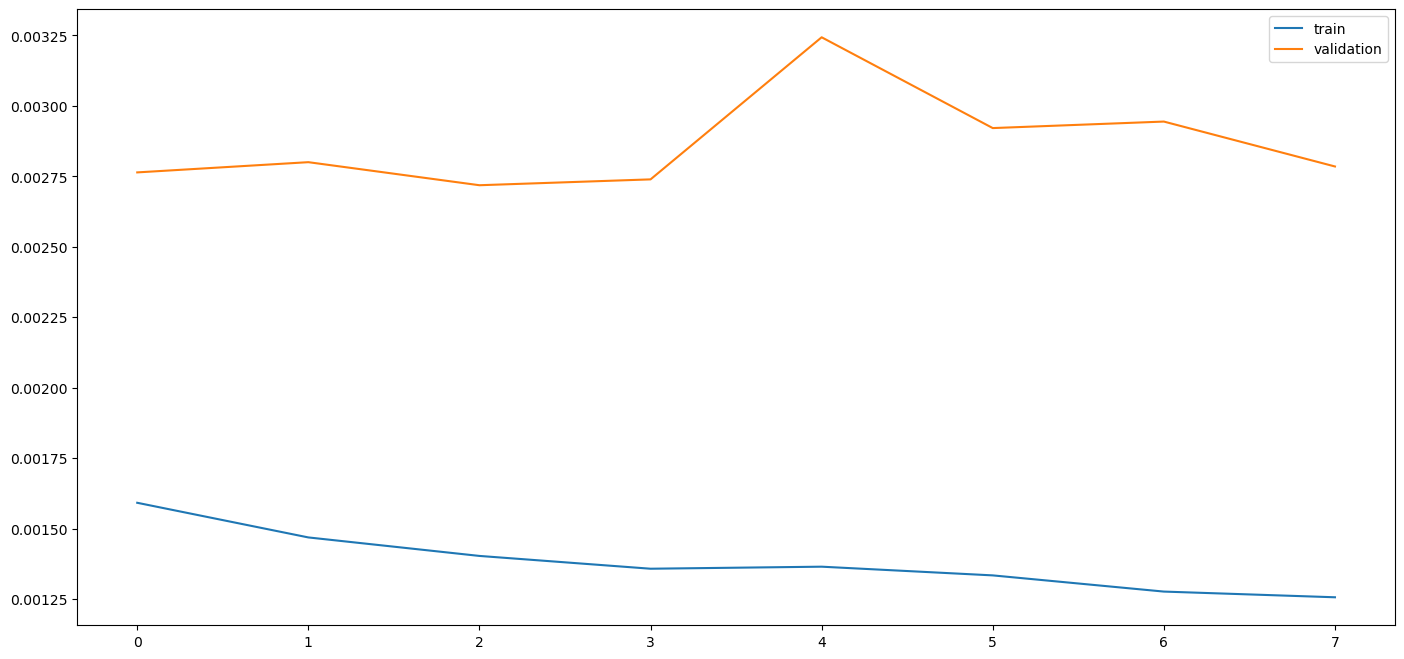

In [194]:
# plot the training and validation loss
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.legend()
plt.show()

# Predicting on the test set

In [195]:
# Reshape X_test_transformed to match the expected input shape
X_test_reshaped = X_test_transformed.reshape((X_test_transformed.shape[0], num_steps, X_test_transformed.shape[2]))

# Make predictions
y_pred = model.predict(X_test_reshaped)

# only take the first column fo y_pred
y_pred = y_pred[:, 0]
y_pred_inversed = mmscaler.inverse_transform(y_pred.reshape(-1, 1))

y_test_pcr = df_test.pcr
# Flatten the nested list y_pred_inversed
y_pred_inversed_flat = [pred[0] for pred in y_pred_inversed]
# place in dataframe
df_pred = pd.DataFrame(y_pred_inversed_flat, columns=['pred'])
y_pred_inversed=df_pred.pred

y_test_pcr = df_test.pcr


2023-06-16 09:43:50.532548: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-16 09:43:50.533910: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-16 09:43:50.535496: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

512/512 [==============================] - 11s 19ms/step


### All stations in one graph

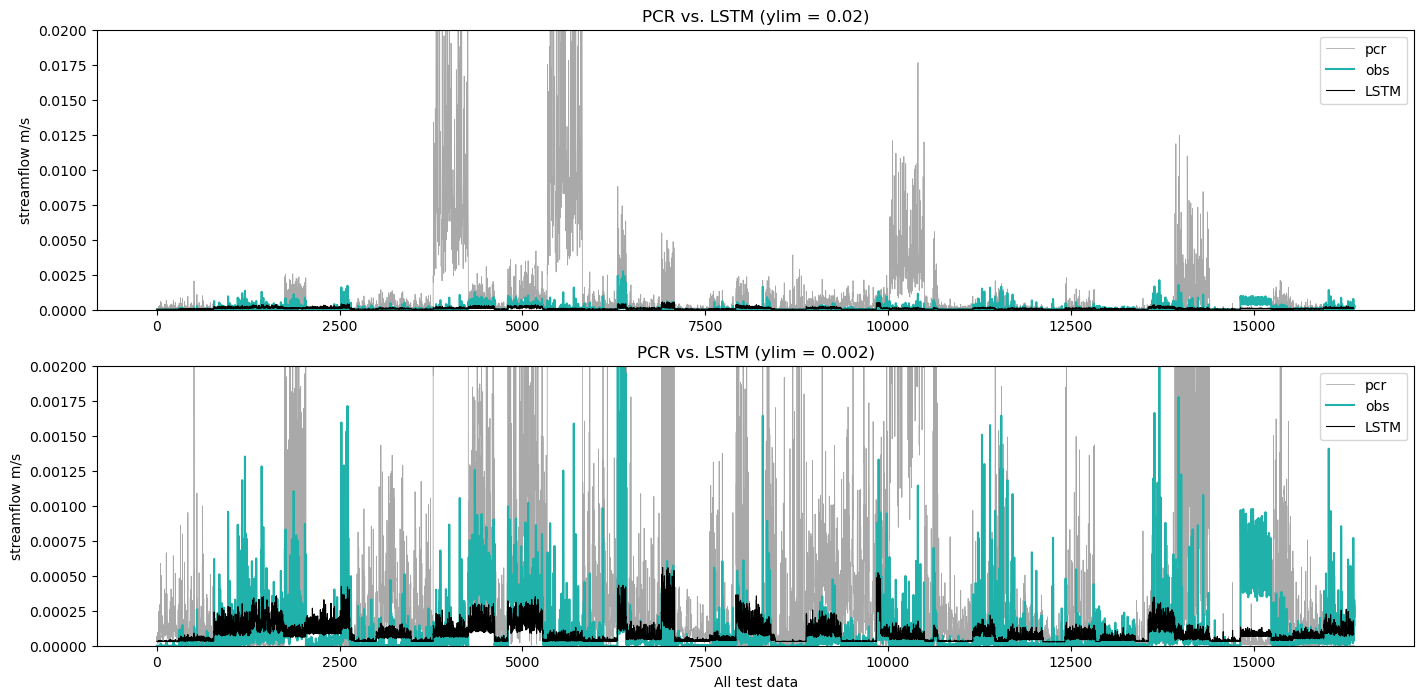

In [197]:
# Plot the results
plt.rcParams["figure.figsize"] = (17, 8)

plt.subplot(2, 1, 1)
plt.title('PCR vs. LSTM (ylim = 0.02)')
plt.plot(y_test_pcr, label='pcr', color='darkgray', linewidth=0.6) 
plt.plot(y_test, label='obs', color='lightseagreen')
plt.ylabel('streamflow m/s')
plt.plot(y_pred_inversed, label='LSTM', color='black', linewidth=0.8)
plt.ylim(0, .02)
plt.legend()

plt.subplot(2, 1, 2)
plt.title('PCR vs. LSTM (ylim = 0.002)')
plt.plot(y_test_pcr, label='pcr', color='darkgrey', linewidth=0.6)
plt.plot(y_test, label='obs', color='lightseagreen')
plt.plot(y_pred_inversed, label='LSTM', linewidth=0.8, color='black')  
plt.ylabel('streamflow m/s')
plt.xlabel('All test data')
plt.ylim(0, .002)
plt.legend()
plt.show()

### Predictions on stations seperately

In [224]:
# copy df_test, y_test_pcr and y_test
df_test_copy = df_test.copy()
y_test_pcr_copy = y_test_pcr.copy()
y_test_copy = y_test.copy()

# 12 values are missing in the test set, because of the lagged variables
# so we remove the first 12 values of y_test_pcr and df_test.Filename and y_test
pcr_plot = y_test_pcr_copy[12:]
obs_plot = y_test_copy[12:]
filename_plot = df_test_copy.Filename[12:]
date_plot =df_test_copy.datetime[12:]
lstm_plot = y_pred_inversed.copy()
print(len(pcr_plot),len(obs_plot),len(filename_plot),len(date_plot), len(lstm_plot))
# get rid of index in filename, date, PCR, and OBS
filename_plot = filename_plot.reset_index(drop=True)
date_plot = date_plot.reset_index(drop=True)
pcr_plot = pcr_plot.reset_index(drop=True)
obs_plot = obs_plot.reset_index(drop=True)
# create one dataframe with all the values
df_results = pd.DataFrame({'Filename': filename_plot, 'Date': date_plot, 'PCR': pcr_plot, 'Obs': obs_plot, 'LSTM': lstm_plot})

16368 16368 16368 16368 16368


In [248]:
# concat all files that have the same filename
path_tables ='/Users/thijskalshoven/Downloads/RF-1/Tables_ALLpredictors'

import os

def concat_files(path_tables):
    tables_df = pd.DataFrame()

    for filename in os.listdir(path_tables):
        if filename.endswith('.csv'):
            file_path = os.path.join(path_tables, filename)
            df = pd.read_csv(file_path, index_col=0)
            df['Filename'] = filename[10:-4]  # Remove the file extension from the filename
            tables_df = pd.concat([tables_df, df])

    return tables_df
# now concat all files of the 5 subsamples

tables_df = concat_files(path_tables)
print(len(tables_df))
tables_df.head()

868872


,obs,pcr,pcr_corrected,res,res_corrected,Filename
datetime,,,,,,
1979-01-01,0.000966,0.001100,0.001095,-0.000134,-0.000130,6342800
1979-02-01,0.001707,0.001663,0.001475,0.000044,0.000231,6342800
1979-03-01,0.001871,0.004028,0.002433,-0.002157,-0.000562,6342800
1979-04-01,0.001889,0.003918,0.002307,-0.002029,-0.000419,6342800
1979-05-01,0.001531,0.005756,0.003512,-0.004224,-0.001981,6342800


In [264]:
filenames = df_results['Filename'].unique()
tables_df['Filename']=tables_df['Filename'].astype(int)

# filename has to be in filenames
tables_df = tables_df[tables_df['Filename'].isin(filenames)]
print(len(tables_df['Filename'].unique()))
tables_df.rename(columns={'PCR_corrected': 'RF (Magni et al., 2023)'}, inplace=True)
tables_df=tables_df[['Filename','RF (Magni et al., 2023)','Date','obs']]

tables_df.head()

47


,Filename,"RF (Magni et al., 2023)",Date,obs
0,5204450,0.000019,1979-01-01,0.000023
1,5204450,0.000015,1979-02-01,0.000007
2,5204450,0.000017,1979-03-01,0.000004
3,5204450,0.000013,1979-04-01,0.000004
4,5204450,0.000019,1979-05-01,0.000005


In [266]:
# left join df_results and tables_df on Filename and datetime
df_results = pd.merge(df_results, tables_df, on=['Filename', 'Date'], how='left')
df_results.head()

,Filename,Date,PCR,Obs,LSTM,"RF (Magni et al., 2023)",obs
0,5204253,1980-03-01,0.000047,6.050660e-07,0.000031,0.000005,6.050660e-07
1,5204253,1980-04-01,0.000028,7.316658e-07,0.000031,0.000005,7.316658e-07
2,5204253,1980-05-01,0.000017,1.797627e-07,0.000032,0.000003,1.797627e-07
3,5204253,1980-06-01,0.000039,5.706753e-09,0.000031,0.000003,5.706753e-09
4,5204253,1980-07-01,0.000064,2.252666e-09,0.000031,0.000002,2.252666e-09


In [350]:
# Output folder for results per Filename
output_folder = '/Users/thijskalshoven/Documents/UU_data_science/6_THESIS_Streamflow_predictions/Figures&Tables/combo_plot'

# Get the unique filenames from the "Filename" column
filenames = df_results['Filename'].unique()

for filename in filenames:
    # Only take the values of one file
    file_data = df_results[df_results['Filename'] == filename]
    # Change date to datetime
    file_data['Date'] = pd.to_datetime(file_data['Date'])

    # Create a figure and subplots for the plots
    # one plot above and two below
    fig, axes = plt.subplots(3, 1, figsize=(27, 19))
    fig.suptitle(f'Catchment {filename} model comparison', fontsize=23)

    # First subplot - PCR, Obs, LSTM
    axes[0].set_title('Predictions', fontsize=25)
    axes[0].plot(file_data['Date'], file_data['PCR'], label='PCR', color='darkgray', linewidth=1.2)
    axes[0].plot(file_data['Date'], file_data['Obs'], label='Streamflow',color='lightseagreen')
    axes[0].plot(file_data['Date'], file_data['LSTM'], label='LSTM-FC', linewidth=4, color='gold', alpha=0.7)
    axes[0].plot(file_data['Date'], file_data['RF (Magni et al., 2023)'], label='RF (Magni et al., 2023)', linewidth=1.2, color='sandybrown')
    axes[0].set_ylabel('streamflow m/d', fontsize=22)
    axes[0].set_xlabel('Date', fontsize=22)
    axes[0].tick_params(axis='x', labelsize=20)
    axes[0].tick_params(axis='y', labelsize=20)
    # plot the legend 
    # axes[0].legend(loc='upper right', fontsize=17, framealpha=0.5)
    

    # Second subplot - Cumulative Probability Distribution
    axes[1].set_title('Cumulative Probability Distribution', fontsize=25)
    # Extract the columns from the dataframe
    observed_streamflow = file_data['Obs']
    lstm = file_data['LSTM']
    pcr = file_data['PCR']
    rf = file_data['RF (Magni et al., 2023)']

    # Sort the data in ascending order
    observed_streamflow_sorted = np.sort(observed_streamflow)
    lstm_sorted = np.sort(lstm)
    pcr_sorted = np.sort(pcr)
    rf_sorted = np.sort(rf)

    # Calculate the cumulative probabilities
    observed_streamflow_cdf = np.arange(1, len(observed_streamflow_sorted) + 1) / len(observed_streamflow_sorted)
    lstm_cdf = np.arange(1, len(lstm_sorted) + 1) / len(lstm_sorted)
    pcr_cdf = np.arange(1, len(pcr_sorted) + 1) / len(pcr_sorted)
    rf_cdf = np.arange(1, len(rf_sorted) + 1) / len(rf_sorted)
    axes[1].plot(observed_streamflow_cdf,observed_streamflow_sorted,  label='Observed streamflow', color='lightseagreen')
    axes[1].plot(lstm_cdf,lstm_sorted, label='LSTM-FC', color='gold')
    axes[1].plot(pcr_cdf,pcr_sorted, label='PCR', color='darkgray')
    axes[1].plot(rf_cdf,rf_sorted, label='RF (Magni et al., 2023)', color='sandybrown')
    axes[1].set_ylabel('streamflow m/d', fontsize=22)
    axes[1].set_xlabel('Probability', fontsize=22)
    axes[1].tick_params(axis='x', labelsize=20)
    axes[1].tick_params(axis='y', labelsize=20)
    # axes[1].legend(loc='upper left', fontsize=17, framealpha=0.5)

    # Third subplot - Cumulative Residuals
    # plot cumulative residuals with only positive values
    axes[2].set_title('Cumulative Residuals', fontsize=25)
    axes[2].scatter(file_data['obs'], (file_data['PCR'] - file_data['Obs']), label='PCR', color='darkgray')
    axes[2].scatter(file_data['obs'], (file_data['LSTM'] - file_data['Obs']), label='LSTM-FC', color='gold')
    axes[2].scatter(file_data['obs'], (file_data['RF (Magni et al., 2023)'] - file_data['Obs']), label='RF (Magni et al., 2023)', color='sandybrown')
    axes[2].invert_yaxis()
    axes[2].set_ylabel('Residuals', fontsize=22)
    axes[2].set_xlabel('Observed streamflow', fontsize=22)
    axes[2].tick_params(axis='x', labelsize=20)
    axes[2].tick_params(axis='y', labelsize=20)
    # axes[2].legend(loc='upper right', fontsize=17)

    plt.subplots_adjust(hspace=0.6)
    # Save the resulting plot in the output folder
    output_filename = os.path.join(output_folder, f'Cathment_{filename}_plot.png')
    plt.savefig(output_filename)
    plt.close()

# KGE comparison of the different models

In [ ]:
# create a function to calculate the KGE
def kge_func(simulation, evaluation):
    # calculate rho
    rho = np.corrcoef(simulation, evaluation)[0, 1]
    # calculate alpha
    alpha = np.std(simulation) / np.std(evaluation)
    # calculate beta
    beta = np.mean(simulation) / np.mean(evaluation)
    # calculate the KGE
    kge = 1 - np.sqrt((rho - 1)**2 + (alpha - 1)**2 + (beta - 1)**2)
    # return the KGE
    return kge

# create empty dataframe
df_kge = pd.DataFrame(columns=['Filename', 'KGE_PCR', 'KGE_LSTM'])
# get the unique filenames
filenames = df_results['Filename'].unique()
# loop through the filenames
for filename in filenames:
    # only take the values of one file
    file_data = df_results[df_results['Filename'] == filename]
    # calculate the kge for PCR and LSTM
    kge_pcr = kge_func(file_data['PCR'], file_data['Obs'])
    kge_lstm = kge_func(file_data['LSTM'], file_data['Obs'])
    # add the values to the dataframe
    df_kge = df_kge.append({'Filename': filename, 'KGE_PCR': kge_pcr, 'KGE_LSTM': kge_lstm}, ignore_index=True)

In [ ]:
KGE_allpredictors = pd.read_csv('/Users/thijskalshoven/Documents/UU_data_science/6_THESIS_Streamflow_predictions/KGE_allpredictors_cumulative.csv')
print('KGE_allpredictors:          ', len(KGE_allpredictors))
print('------')

#only leave locations with KGE < -0.41
KGE_ALL_predictors_low = KGE_allpredictors[KGE_allpredictors['KGE'] < -0.41]
print('KGE_predictors_low:         ', len(KGE_ALL_predictors_low))
KGE_ALL_predictors_low=KGE_ALL_predictors_low[['grdc_no', 'KGE']]
print('------')
print('KGE_predictors_low:         ', len(KGE_ALL_predictors_low))

# group by grdc_no and take the mean of KGE
KGE_ALL_predictors_low=KGE_ALL_predictors_low.groupby(['grdc_no']).mean()
print(len(KGE_ALL_predictors_low))
# save as csv
KGE_ALL_predictors_low.to_csv('/Users/thijskalshoven/Documents/UU_data_science/6_THESIS_Streamflow_predictions/KGE_ALL_predictors_low.csv')

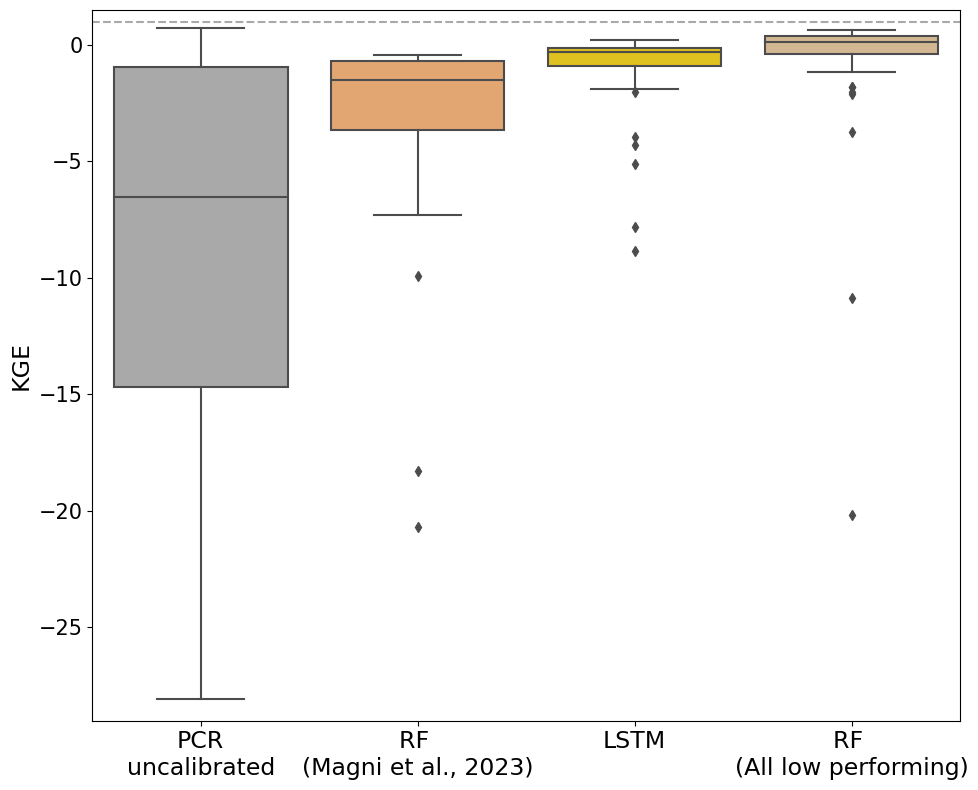

In [353]:
RF_KGE= pd.read_csv('/Users/thijskalshoven/Documents/UU_data_science/6_THESIS_Streamflow_predictions/KGE_ALL_predictors_low.csv')

# only keep grdc_no which are in filenames
RF_KGE = RF_KGE[RF_KGE['grdc_no'].isin(filenames)]
len(RF_KGE)
# inner join the two dataframes on Filename and grdc_no
df_kge2 = df_kge.merge(RF_KGE, left_on='Filename', right_on='grdc_no', how='inner')
RF_new = pd.read_csv('/Users/thijskalshoven/Documents/UU_data_science/6_THESIS_Streamflow_predictions/Data/GitHub/OUTPUT_MAGNI/RF/3_validate/KGE_mean_cum.csv')
# inner join once more 
df_kge3 = df_kge2.merge(RF_new, left_on='Filename', right_on='grdc_no', how='inner')

# boxplot of the KGE values limit y-axis to from -50 to 10
import seaborn as sns
colors = ['darkgray', 'sandybrown', 'gold', 'burlywood']

# Create the boxplot using seaborn
# make plot very tall and not too wide
plt.figure(figsize=(10,8))
sns.boxplot(data=df_kge3[['KGE_PCR', 'KGE', 'KGE_LSTM','KGE_corrected']], palette=colors )
plt.ylabel('KGE', fontsize=17)
plt.xticks([0, 1, 2, 3], ['PCR\nuncalibrated', 'RF \n(Magni et al., 2023)', 'LSTM-FC', 'RF \n(All low performing)'], fontsize=17)
plt.axhline(y=1, color='darkgrey', linestyle='--')
plt.tick_params(axis='y', labelsize=15)
plt.ylim(-29, 1.5)
plt.tight_layout()
plt.show()

# EXTRA: 
## Hyperparameter tuning

In [88]:
# Define the function for building the model
def build_model(hp):
    model = Sequential()
    model.add(LSTM(units=hp.Int('input_unit', min_value=480, max_value=512, step=32), return_sequences=True))
    for i in range(hp.Int('n_layers', 2, 4)):
        model.add(LSTM(units=hp.Int(f'lstm_{i}_units', min_value=256, max_value=256, step=32), return_sequences=True))
    model.add(Dense(units=hp.Int('layer_2_neurons', min_value=256, max_value=256, step=32), activation=hp.Choice('dense_activation', values=['relu'], default='relu')))
    model.add(Dropout(0.4))
    model.add(Dense(units=1, activation='linear'))

    model.compile(loss='mean_squared_error', optimizer=keras.optimizers.Adam(hp.Choice('learning_rate', values=[0.001])), metrics=['mse'])
    return model

# Instantiate the Hyperband tuner
tuner = kt.Hyperband(build_model,
                     objective='val_loss',
                     max_epochs=30,
                     factor=3,
                     hyperband_iterations=1,
                     directory='/Users/thijskalshoven/Documents/UU_data_science/6_THESIS_Streamflow_predictions/Data/LSTM/hyperparameter_tuning/',
                     project_name='LSTM_hyperparameter_tuning')

# Search for the best hyperparameters
tuner.search(X_train_transformed, y_train_transformed,
             validation_split=0.2,
             epochs=30,
             batch_size=64,
             callbacks=[EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=7, restore_best_weights=True)])

# Get the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# Build the final model with the best hyperparameters
final_model = tuner.hypermodel.build(best_hps)

# Train the final model
history = final_model.fit(X_train_transformed, y_train_transformed,
                          validation_split=0.2,
                          epochs=30,
                          batch_size=64,
                          callbacks=[EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=8, restore_best_weights=True)])

Trial 12 Complete [00h 04m 57s]
val_loss: 0.0025948230177164078

Best val_loss So Far: 0.002395954681560397
Total elapsed time: 00h 44m 19s
INFO:tensorflow:Oracle triggered exit


Epoch 1/30


2023-06-12 10:04:30.309110: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-12 10:04:30.310649: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-12 10:04:30.312217: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

482/482 [==============================] - ETA: 0s - loss: 0.0016 - mse: 0.0016

2023-06-12 10:06:16.763033: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-12 10:06:16.764896: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-12 10:06:16.766386: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

482/482 [==============================] - 116s 225ms/step - loss: 0.0016 - mse: 0.0016 - val_loss: 0.0028 - val_mse: 0.0028
Epoch 2/30
482/482 [==============================] - 108s 224ms/step - loss: 0.0015 - mse: 0.0015 - val_loss: 0.0026 - val_mse: 0.0026
Epoch 3/30
482/482 [==============================] - 100s 208ms/step - loss: 0.0014 - mse: 0.0014 - val_loss: 0.0031 - val_mse: 0.0031
Epoch 4/30
482/482 [==============================] - 101s 209ms/step - loss: 0.0014 - mse: 0.0014 - val_loss: 0.0030 - val_mse: 0.0030
Epoch 5/30
482/482 [==============================] - 100s 208ms/step - loss: 0.0013 - mse: 0.0013 - val_loss: 0.0027 - val_mse: 0.0027
Epoch 6/30
482/482 [==============================] - 100s 208ms/step - loss: 0.0013 - mse: 0.0013 - val_loss: 0.0031 - val_mse: 0.0031
Epoch 7/30
482/482 [==============================] - 100s 207ms/step - loss: 0.0013 - mse: 0.0013 - val_loss: 0.0037 - val_mse: 0.0037
Epoch 8/30
482/482 [==============================] - 99s 2

In [89]:
# geting optimal params in a dict to save it
best_trial = tuner.oracle.get_best_trials(num_trials=1)[0].hyperparameters.values

# reading optimal params in a df
dict_ = tuner.oracle.get_best_trials(num_trials=1)[0].hyperparameters.values
lstm_best_params = pd.DataFrame([dict_])
lstm_best_params

,input_unit,n_layers,lstm_0_units,layer_2_neurons,dense_activation,learning_rate,lstm_1_units,lstm_2_units,lstm_3_units,lstm_4_units,tuner/epochs,tuner/initial_epoch,tuner/bracket,tuner/round
0,512,3,256,256,relu,0.001,256,256,256,256,2,0,3,0
